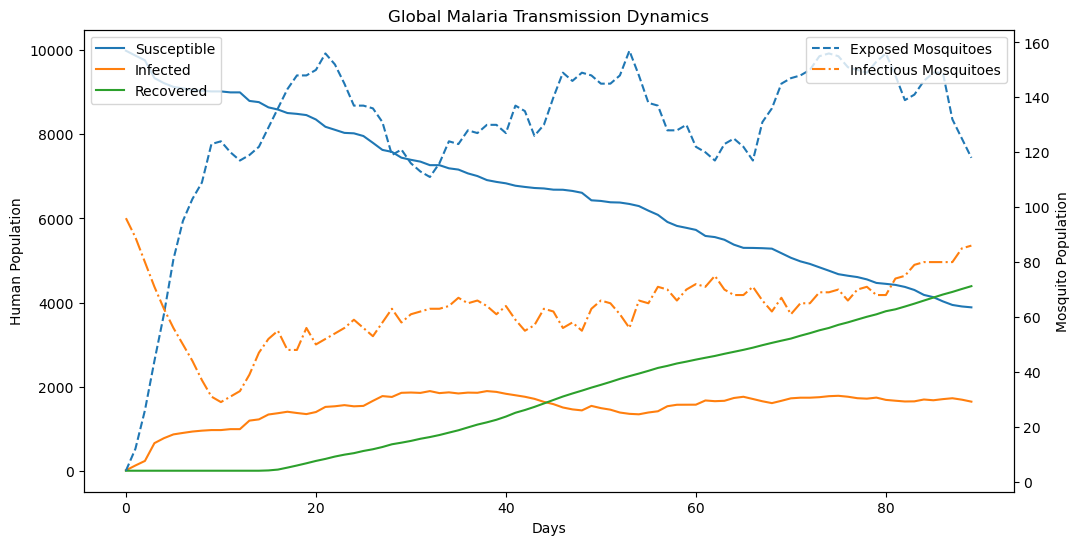

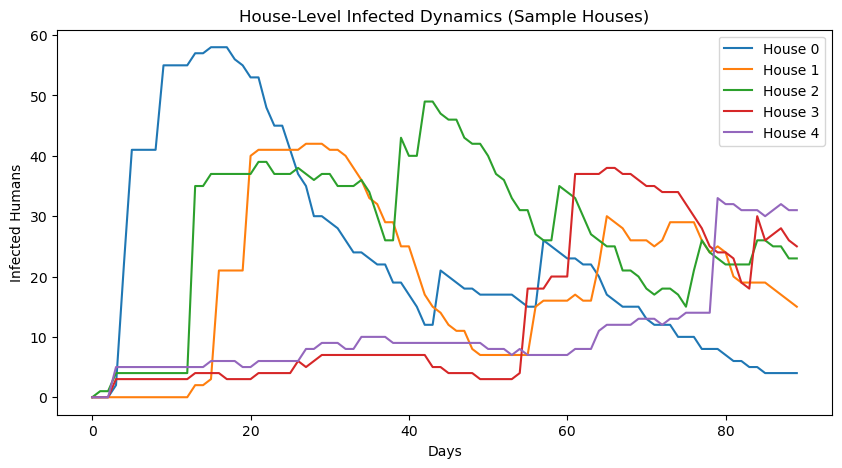

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Network:
    def __init__(self, name):
        self.name = name
        self.nodes = {}  # {node_id: set(agent_ids)}
        self.adjacency = {}  # {node_id: [connected_nodes]}
    
    def add_node(self, node_id):
        if node_id not in self.nodes:
            self.nodes[node_id] = set()
            self.adjacency[node_id] = []
    
    def connect_nodes(self, src, dest):
        if src in self.nodes and dest in self.nodes:
            self.adjacency[src].append(dest)
            self.adjacency[dest].append(src)
    
    def add_agent(self, node_id, agent_id):
        if node_id in self.nodes:
            self.nodes[node_id].add(agent_id)
    
    def remove_agent(self, node_id, agent_id):
        if node_id in self.nodes:
            self.nodes[node_id].discard(agent_id)
    
    def get_agents(self, node_id):
        return self.nodes.get(node_id, set())

class Human:
    def __init__(self, uid):
        self.id = uid
        self.state = 'S'  # S, I, R
        self.home = None
        self.work = None
        self.current_location = None
        self.infected_day = -1
        self.age = random.randint(15, 60)
    
    def move(self, new_network, new_node):
        if self.current_location:
            old_net, old_node = self.current_location
            old_net.remove_agent(old_node, self.id)
        new_network.add_agent(new_node, self.id)
        self.current_location = (new_network, new_node)

class Mosquito:
    def __init__(self, uid):
        self.id = uid
        self.state = 'S'  # S, E, I
        self.breeding_site = None
        self.current_location = None
        self.exposed_day = -1
        self.age = random.randint(1, 30)
    
    def move(self, new_network, new_node):
        if self.current_location:
            old_net, old_node = self.current_location
            old_net.remove_agent(old_node, self.id)
        new_network.add_agent(new_node, self.id)
        self.current_location = (new_network, new_node)

class MalariaSimulation:
    def __init__(self):
        self.humans = []
        self.mosquitoes = []
        self.day = 0
        self.hour = 0
        
        # Initialize networks
        self.houses = Network("Houses")
        self.workplaces = Network("Workplaces")
        self.breeding_sites = Network("BreedingSites")
        
        # Create network nodes
        for i in range(100):
            self.houses.add_node(i)
        for i in range(20):
            self.workplaces.add_node(i)
        for i in range(50):
            self.breeding_sites.add_node(i)
        
        # More "realistic" malaria parameters (daily basis)
        self.a = 0.3 / 24     # Hourly biting probability (~30% per day, spread over 24 hours)
        self.b = 0.2          # Probability human becomes infected if bitten by infectious mosquito
        self.c = 0.1          # Probability mosquito gets infected from biting infected human
        self.r = 1/14         # Human recovery rate (~14 days for recovery)
        self.mu_m = 0.1       # Daily mosquito mortality
        self.tau_m = 10       # Extrinsic incubation period (days) in mosquito
        self.mu_h = 0.0001    # Daily human mortality
        
        # Initialize populations
        self.init_populations()
        
        # ----- Global stats history -----
        self.history = {
            'S': [], 'I': [], 'R': [],
            'E_mos': [], 'I_mos': [],
            'total': []
        }
        
        # ----- House-level time-series for infected humans (as an example) -----
        # We'll store an array for each house, updated daily for the number of infected humans.
        # If you want S or R as well, just replicate the approach.
        self.house_infected_series = {house_id: [] for house_id in self.houses.nodes}
    
    def init_populations(self):
        # Create 10,000 humans
        for i in range(10000):
            human = Human(i)
            home = random.choice(list(self.houses.nodes.keys()))
            work = random.choice(list(self.workplaces.nodes.keys()))
            human.home = (self.houses, home)
            human.work = (self.workplaces, work)
            human.move(*human.home)
            # Initialize a few humans as infected
            if i < 10:
                human.state = 'I'
                human.infected_day = 0
            self.humans.append(human)
        
        # Create 5,000 mosquitoes
        for i in range(5000):
            mosquito = Mosquito(10000 + i)
            site = random.choice(list(self.breeding_sites.nodes.keys()))
            mosquito.breeding_site = (self.breeding_sites, site)
            mosquito.move(*mosquito.breeding_site)
            # Initialize some mosquitoes as infected
            if i < 100:
                mosquito.state = 'I'
            self.mosquitoes.append(mosquito)
    
    def schedule_movement(self):
        current_hour = self.hour % 24
        # Move humans to work or home
        for human in self.humans:
            if 8 <= current_hour < 18:  # Work hours
                if human.current_location != human.work:
                    human.move(*human.work)
            else:  # Home hours
                if human.current_location != human.home:
                    human.move(*human.home)
        
        # Randomly move mosquitoes
        for mosquito in self.mosquitoes:
            if random.random() < 0.1:  # 10% chance each hour
                if current_hour > 18 or current_hour < 6:  # Night movement
                    target = random.choice([
                        *self.houses.nodes.keys(),
                        *self.workplaces.nodes.keys()
                    ])
                    net = random.choice([self.houses, self.workplaces])
                else:
                    net = self.breeding_sites
                    target = random.choice(list(net.nodes.keys()))
                mosquito.move(net, target)
    
    def handle_infections(self):
        # Collect all locations with humans
        human_locations = {}
        for human in self.humans:
            net, node = human.current_location
            key = (net.name, node)
            if key not in human_locations:
                human_locations[key] = []
            human_locations[key].append(human)
        
        # Check mosquito-human overlaps
        for mosquito in self.mosquitoes:
            m_net, m_node = mosquito.current_location
            key = (m_net.name, m_node)
            if key in human_locations:
                humans = human_locations[key]
                
                # If mosquito is infectious, it can infect humans
                if mosquito.state == 'I' and random.random() < self.a:
                    for human in humans:
                        if human.state == 'S' and random.random() < self.b:
                            human.state = 'I'
                            human.infected_day = self.day
                
                # If mosquito is susceptible, it can get infected from infected humans
                elif mosquito.state == 'S':
                    infected_humans = [h for h in humans if h.state == 'I']
                    if infected_humans and random.random() < self.a:
                        if random.random() < self.c:
                            mosquito.state = 'E'
                            mosquito.exposed_day = self.day
    
    def update_states(self):
        # Human recovery and mortality
        new_humans = []
        for human in self.humans:
            # Attempt recovery after ~14 days infected
            if human.state == 'I' and (self.day - human.infected_day) >= 14:
                if random.random() < self.r:
                    human.state = 'R'
            
            # Human mortality check (daily)
            if random.random() < self.mu_h:
                if human.current_location:
                    net, node = human.current_location
                    net.remove_agent(node, human.id)
                continue  # This human dies and is removed
            
            new_humans.append(human)
        self.humans = new_humans
        
        # Mosquito state transitions and mortality
        new_mosquitoes = []
        for mosquito in self.mosquitoes:
            # Incubation period
            if mosquito.state == 'E' and (self.day - mosquito.exposed_day) >= self.tau_m:
                mosquito.state = 'I'
            
            # Mosquito mortality check (daily)
            if random.random() < self.mu_m:
                if mosquito.current_location:
                    net, node = mosquito.current_location
                    net.remove_agent(node, mosquito.id)
                continue  # This mosquito dies and is removed
            
            new_mosquitoes.append(mosquito)
        
        # Repopulate mosquitoes to maintain around 5000
        target_count = 5000
        while len(new_mosquitoes) < target_count:
            new_id = 10000 + len(new_mosquitoes)
            mosquito = Mosquito(new_id)
            site = random.choice(list(self.breeding_sites.nodes.keys()))
            mosquito.move(self.breeding_sites, site)
            new_mosquitoes.append(mosquito)
        
        self.mosquitoes = new_mosquitoes
    
    def step(self):
        # Each step spans 24 hours
        for _ in range(24):
            self.schedule_movement()
            self.handle_infections()
            self.hour += 1
        
        self.update_states()
        self.record_stats()
        self.day += 1
    
    def record_stats(self):
        """Record daily overall stats and house-level infected time-series."""
        
        # ----- Global totals -----
        S = sum(1 for h in self.humans if h.state == 'S')
        I = sum(1 for h in self.humans if h.state == 'I')
        R = sum(1 for h in self.humans if h.state == 'R')
        E_mos = sum(1 for m in self.mosquitoes if m.state == 'E')
        I_mos = sum(1 for m in self.mosquitoes if m.state == 'I')
        
        self.history['S'].append(S)
        self.history['I'].append(I)
        self.history['R'].append(R)
        self.history['E_mos'].append(E_mos)
        self.history['I_mos'].append(I_mos)
        self.history['total'].append(len(self.humans))
        
        # ----- House-level infected series -----
        # For each house node, count how many infected humans it has at the end of the day
        for house_id, agent_ids in self.houses.nodes.items():
            i_h = 0
            for agent_id in agent_ids:
                # Humans have id < 10000
                if agent_id < 10000:
                    h = next((h for h in self.humans if h.id == agent_id), None)
                    if h and h.state == 'I':
                        i_h += 1
            # Append daily infected count for this house
            self.house_infected_series[house_id].append(i_h)
    
    def plot_results(self):
        days = np.arange(len(self.history['S']))
        
        # --- Global Plot ---
        plt.figure(figsize=(12,6))
        plt.plot(days, self.history['S'], label='Susceptible')
        plt.plot(days, self.history['I'], label='Infected')
        plt.plot(days, self.history['R'], label='Recovered')
        plt.xlabel('Days')
        plt.ylabel('Human Population')
        plt.legend(loc='upper left')
        
        plt.twinx()
        plt.plot(days, self.history['E_mos'], '--', label='Exposed Mosquitoes')
        plt.plot(days, self.history['I_mos'], '-.', label='Infectious Mosquitoes')
        plt.ylabel('Mosquito Population')
        plt.legend(loc='upper right')
        plt.title('Global Malaria Transmission Dynamics')
        plt.show()
        
        # --- House-Level Plot (Infected Humans) ---
        # Let’s pick a handful of houses to avoid clutter, e.g. first 5 houses
        houses_to_plot = [0, 1, 2, 3, 4]
        plt.figure(figsize=(10,5))
        for house_id in houses_to_plot:
            plt.plot(days, self.house_infected_series[house_id], label=f"House {house_id}")
        
        plt.xlabel("Days")
        plt.ylabel("Infected Humans")
        plt.title("House-Level Infected Dynamics (Sample Houses)")
        plt.legend()
        plt.show()

# Run simulation
sim = MalariaSimulation()
for _ in range(90):
    sim.step()

sim.plot_results()
